In [1]:
import findspark
import pyspark
import pandas as pd
from pyspark.sql import SQLContext
import sys
import matplotlib.pyplot as plt
sys.path.append(r'C:\Users\Dirac\anaconda3clean\envs\myenv\Lib\site-packages')
findspark.init(r'C:\Users\Dirac\spark-3.0.0-bin-hadoop2.7')
sc = pyspark.SparkContext()
sqlCtx = SQLContext(sc)

In [2]:
data = sqlCtx.read.format("csv").option("header", "true").load("all_data.csv")
data.registerTempTable('profeco')
#test = sqlCtx.read.format("csv").option("header", "true").load("test.csv")
#test.registerTempTable('profeco')

In [3]:
data.printSchema()

root
 |-- producto: string (nullable = true)
 |-- presentacion: string (nullable = true)
 |-- marca: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- catalogo: string (nullable = true)
 |-- precio: string (nullable = true)
 |-- fechaRegistro: string (nullable = true)
 |-- cadenaComercial: string (nullable = true)
 |-- giro: string (nullable = true)
 |-- nombreComercial: string (nullable = true)
 |-- direccion: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- latitud: string (nullable = true)
 |-- longitud: string (nullable = true)



## Procesamiento de los datos

**a)**  El número de registros lo podemos calcular por medio de la función `count()`, ya que cada fila corresponde a un distinto registro:

In [17]:
data.count()  #62,530,715

62530715

**b**) El número de categorías es 42:

In [8]:
query_cat = ''' SELECT 
                      COUNT(*) AS num_categorias
                FROM (
                      SELECT 
                            DISTINCT categoria
                      FROM profeco
                      ) '''

sqlCtx.sql(query_cat).show()

+--------------+
|num_categorias|
+--------------+
|            42|
+--------------+



**c**) El número de cadenas comerciales monitoreadas es 706.

In [9]:
query_cad = ''' SELECT 
                      COUNT(*) AS num_cadenas
                FROM (
                      SELECT 
                            DISTINCT cadenaComercial
                      FROM profeco
                      ) '''

sqlCtx.sql(query_cad).show()

+-----------+
|num_cadenas|
+-----------+
|        706|
+-----------+



**d**) Para empezar, el calcular la proporción de datos faltantes en las columnas podría ser útil. En particular, calcular los datos faltantes en la columna `count()` es importante ya que estas filas probablemente se hayan introducido incorrectamente a la base de datos porque sin producto un registro no tendría sentido:

In [12]:
query_null_prop = '''SELECT 
                           CAST (SUM (CASE 
                                          WHEN producto is NULL 
                                              THEN 1 
                                          ELSE 0 
                                      END) as float) / COUNT(*) AS prop_faltante
                     FROM profeco  '''

sqlCtx.sql(query_null_prop).show()

+-------------+
|prop_faltante|
+-------------+
|          0.0|
+-------------+



Se observa que la proporción de datos faltante en la columna es 0, lo que indica que afortunadamente todos los registros tienen al menos un producto asociado.

Otra columna que valdría la pena analizar para determinar la calidad de los datos es la columna de precios. Se podría calcular igual que con `producto` su proporción de valores faltantes, y además se podrían calcular sus valores máximos y mínimos, la media y la desviación estándar y así poder descartar valores sin sentido (cepillos de 1 millón de pesos o carros gratuitos, por ejemplo), y a su vez descartar filas con valores de precio faltantes haya ya que esto podría afectar el rendimiento de algoritmos de ML, siendo la única variable numérica, continua y de razón de los datos (aunque podríamos jugar con las coordenadas también).


También se podrían buscar filas repetidas, tales como productos que están listados como dos registros distintas con nombres que únicamente difieren en el uso de mayúsculas o minúsculas ('Perro' y 'PeRro' como dos productos distintos, por ejemplo), o filas correspondientes a exactamente el mismo producto pero reportados en estados o municipios distintos.

**e)** Se calculan los productos más monitoreados en cada entidad:

In [4]:
query_most_monitored = ''' WITH pea AS    (
                                           SELECT
                                                 producto,
                                                 estado,
                                                 COUNT(*) AS num_monitoreados         
                                           FROM profeco
                                           WHERE producto != 'VARIOS'
                                           GROUP BY producto, estado
                                           ORDER BY num_monitoreados DESC
                                          ),
                                       
                        est_prod_class AS
                                           (
                                            SELECT
                                                  peaz.estado estado,
                                                  peaz.producto producto,
                                                  peaz.num_monitoreados max_num_monitoreados,
                                                  CASE
                                                     WHEN (
                                                           SELECT 
                                                                 MAX(peas.num_monitoreados)
                                                           FROM pea AS peas
                                                           WHERE peas.estado = peaz.estado
                                                           ) = num_monitoreados THEN 1
                                                     ELSE 0
                                                  END AS max_bool    
                                            FROM pea as peaz
                                            )
                                            
                    
                                            SELECT 
                                                 estado,
                                                 producto,
                                                 max_num_monitoreados
                                            FROM est_prod_class
                                            WHERE max_bool = 1
                                            '''     

sqlCtx.sql(query_most_monitored).show(50, False)     #Quitamos 'VARIOS' de los productos que clasificamos

+-------------------------------+-----------------------+--------------------+
|estado                         |producto               |max_num_monitoreados|
+-------------------------------+-----------------------+--------------------+
|DISTRITO FEDERAL               |REFRESCO               |287463              |
|MÉXICO                         |REFRESCO               |194939              |
|JALISCO                        |REFRESCO               |81718               |
|NUEVO LEÓN                     |DETERGENTE P/ROPA      |50307               |
|GUANAJUATO                     |REFRESCO               |49441               |
|TLAXCALA                       |REFRESCO               |43904               |
|MICHOACÁN DE OCAMPO            |DETERGENTE P/ROPA      |40144               |
|BAJA CALIFORNIA                |REFRESCO               |37243               |
|YUCATÁN                        |LECHE ULTRAPASTEURIZADA|35991               |
|QUINTANA ROO                   |FUD                

Regresando a la pregunta d), se observa como hay irregularidades en las columna 'estado' y 'producto' los cuales se reflejan al final de la tabla anterior pero que afortunadamente no afectan la interpretación de los resultados.

**f** La cadena comercial con mayor variedad de productos monitoreados es Soriana.

In [5]:
query_chain_more_variety = '''SELECT 
                                     cadenaComercial,
                                     COUNT(DISTINCT producto) num_dist_productos
                              FROM profeco
                              GROUP BY cadenaComercial
                              ORDER BY num_dist_productos DESC  '''        
                                                                    
sqlCtx.sql(query_chain_more_variety).show(50, False)

+-------------------------------------+------------------+
|cadenaComercial                      |num_dist_productos|
+-------------------------------------+------------------+
|SORIANA                              |1059              |
|WAL-MART                             |1051              |
|MEGA COMERCIAL MEXICANA              |1049              |
|COMERCIAL MEXICANA                   |1036              |
|CHEDRAUI                             |1026              |
|MERCADO SORIANA                      |1024              |
|BODEGA AURRERA                       |1012              |
|HIPERMERCADO SORIANA                 |1006              |
|H.E.B.                               |1001              |
|SORIANA PLUS                         |999               |
|SORIANA SUPER                        |996               |
|BODEGA COMERCIAL MEXICANA            |979               |
|I.S.S.S.T.E.                         |937               |
|SUPERAMA                             |936              

## 2) Análisis Exploratorio

**a)** Seleccione refrescos, aceites, detergentes y desodorantes como las partes de la canasta básica. Es apropiado seleccionar productos cuyo precio sea similar y que prácticamente se puedan encontrar en todas las tiendas y casas del país sin importar los niveles de riqueza o delincuencia de la zona en donde se encuentran. Además, son artículos de tan alta necesidad que su precio está estandarizado en toda la república y cualquier pequeño incremento en su precio será proporcional a un incremento directo de los impuestos y plusvalía de una zona.

Escogí dos productos comestibles y dos de uso personal para abarcar un mayor número de cadenas comerciales, y traté de escoger productos que no sean de temporada o que dependan de las creencias y costumbres de la gente (por ejemplo, no escogí carne porque pueden influir varios factores en su consumo tales como ser vegetariano, estar a dieta, ser judio, etc). Por último, se puede argüir si refresco es de alta necesidad, pero lo escogí debido a su altísimo consumo en la república Mexicana y porque es el producto más monitoreado de todos.

Si llegara a haber variaciones geográficas en los precios de estos cuatro productos tan básicos es probable que se deban a un problema de suministros en la región en donde surgió la variación (lugar muy remoto, problemas con la delincuencia organizada, etc) y si hay variaciones temporales probablemente se deban a procesos macroeconómicos y no a nivel local, tales como una recesión o la inflación.

In [6]:
canasta_basica = ['REFRESCO', 'ACEITE', 'DETERGENTE P/ROPA', 'DESODORANTE']

**b)** El municipio más caro del país de acuerdo al siguiente query es San Pedro Garza García, que no es considerada ciudad y puede ser que los altos precios no se generalicen al resto de la ciudad de Monterrey. Huixquilucan si es considerada ciudad y cuenta con zonas residenciales y comerciales de élite, razón de esos precios de canasta básica tan altos. Tlaquepaque también es ciudad y tiene altos niveles de turismo extranjero, por lo que el precio de la canasta básica también crece.

Por lo tanto, la ciudad más cara es Huixquilucan.

In [7]:
query_most_expensive_city = '''WITH pre as (
                                             SELECT 
                                                   municipio,
                                                   producto,
                                                   ROUND(AVG(CAST(precio as float)), 2) precio_promedio,
                                                   COUNT(precio) num_registros
                                             FROM profeco
                                             WHERE producto IN ('REFRESCO', 'ACEITE', 'DETERGENTE P/ROPA', 'DESODORANTE')
                                             GROUP BY municipio, producto
                                             HAVING num_registros > 20
                                             ORDER BY producto, precio_promedio DESC
                                             )
                               
                                              SELECT municipio,
                                                     ROUND(SUM(precio_promedio),2) precio_canasta
                                              FROM pre
                                              GROUP BY municipio
                                              HAVING COUNT(municipio) = 4
                                              ORDER BY precio_canasta DESC'''        
                                                                    
sqlCtx.sql(query_most_expensive_city).show(300, False)

+----------------------------------------+--------------+
|municipio                               |precio_canasta|
+----------------------------------------+--------------+
|SAN PEDRO GARZA GARCÍA                  |138.8         |
|TLAQUEPAQUE                             |129.68        |
|HUIXQUILUCAN                            |127.92        |
|ENSENADA                                |123.83        |
|AGUA PRIETA                             |123.27        |
|NOGALES                                 |122.55        |
|MEXICALI                                |122.49        |
|LA PAZ                                  |122.28        |
|BOCA DEL RÍO                            |121.96        |
|CULIACÁN                                |121.76        |
|SAN NICOLÁS DE LOS GARZA                |121.5         |
|TEPIC                                   |121.07        |
|NOGALES                                 |120.94        |
| CP. 27280"                             |120.63        |
|REYNOSA      

**c)** Se encontró que el precio de la canasta básica a nivel nacional incrementó de forma monótona desde 2011 hasta 2016 (años cubiertos por el dataset), lo cual es producto probablemente de la inflación anual.

In [8]:
query_by_year= '''WITH datos_anios AS (
                                       SELECT 
                                             producto,
                                             municipio,
                                             estado,
                                             precio,
                                             EXTRACT(YEAR FROM fechaRegistro) AS anio
                                       FROM profeco
                                       WHERE producto in ('REFRESCO', 'ACEITE', 'DETERGENTE P/ROPA', 'DESODORANTE')
                                       )
                  
                                       SELECT 
                                              anio,
                                              ROUND(SUM(precio_prom), 2) precio_canasta                                              
                                       FROM (
                                              SELECT 
                                                    anio,
                                                    producto,
                                                    AVG(precio) precio_prom
                                              FROM datos_anios
                                              GROUP BY anio, producto
                                            )
                                       GROUP BY anio
                                       ORDER BY anio ASC                   
                     
                     '''

sqlCtx.sql(query_by_year).show(50, False)

+----+--------------+
|anio|precio_canasta|
+----+--------------+
|2011|103.78        |
|2012|108.19        |
|2013|108.26        |
|2014|110.67        |
|2015|114.56        |
|2016|122.1         |
+----+--------------+



También se encontró que el precio de la canasta básica se mantiene relativamente estable en todas las temporadas del año ($\pm 2$ pesos mexicanos) y esto verifica que la elección de los productos de la canasta fue adecuada.

In [9]:
query_by_season= '''WITH datos_meses AS (
                                         SELECT 
                                               producto,
                                               municipio,
                                               fechaRegistro,
                                               estado,
                                               precio,
                                               EXTRACT(MONTH FROM fechaRegistro) AS mes
                                          FROM profeco
                                          WHERE producto in ('REFRESCO', 'ACEITE', 'DETERGENTE P/ROPA', 'DESODORANTE')
                                          )
                  
                                         SELECT 
                                                temporada,
                                                ROUND(SUM(precio_prom), 2) precio_canasta
                                         FROM (
                                                SELECT
                                                      CASE 
                                                          WHEN mes in ('1', '2', '3') THEN 'Enero-Marzo' 
                                                          WHEN mes in ('4', '5', '6') THEN 'Abril-Junio' 
                                                          WHEN mes in ('7', '8', '9') THEN 'Julio-Septiembre' 
                                                          WHEN mes in ('10', '11', '12') THEN 'Octubre-Diciembre' 
                                                      END as temporada,
                                                      producto,
                                                      AVG(precio) precio_prom
                                                 FROM datos_meses
                                                 GROUP BY temporada, producto
                                               )
                                         GROUP BY temporada
                                         ORDER BY temporada DESC
                  
                     
                     
                     '''

sqlCtx.sql(query_by_season).show(300, False)

+-----------------+--------------+
|temporada        |precio_canasta|
+-----------------+--------------+
|Octubre-Diciembre|111.45        |
|Julio-Septiembre |110.16        |
|Enero-Marzo      |112.06        |
|Abril-Junio      |110.2         |
+-----------------+--------------+



**d)** El estado más caro del país es Baja California.

In [10]:
query_most_exp_state = '''WITH data_estado (SELECT producto,
                          estado,
                          AVG(precio) precio_prom
                          FROM profeco
                          WHERE producto in ('REFRESCO', 'ACEITE', 'DETERGENTE P/ROPA', 'DESODORANTE')
                          GROUP BY estado, producto)
                          
                          SELECT estado,
                                 SUM(precio_prom) costo_canasta
                          FROM data_estado
                          GROUP BY estado
                          HAVING COUNT(estado) = 4
                          ORDER BY costo_canasta DESC
                          
                        '''
sqlCtx.sql(query_most_exp_state).show(300, False)

+-------------------------------+------------------+
|estado                         |costo_canasta     |
+-------------------------------+------------------+
| COL. EDUARDO GUERRA           |120.62994751184056|
|BAJA CALIFORNIA                |120.36502655108644|
|BAJA CALIFORNIA SUR            |119.9445172530803 |
|NAYARIT                        |118.61464384175127|
|SAN LUIS POTOSÍ                |118.16196025683828|
|SONORA                         |117.55226080790024|
|TAMAULIPAS                     |116.99790619405785|
|CHIHUAHUA                      |115.74946047328515|
|DURANGO                        |115.05001020015865|
|GUERRERO                       |113.98397021267337|
|COAHUILA DE ZARAGOZA           |113.85883568053822|
|SINALOA                        |113.37566931176751|
|QUINTANA ROO                   |112.16513873758255|
|GUANAJUATO                     |111.85068811726069|
|MORELOS                        |111.46071975057352|
|AGUASCALIENTES                 |111.275555745

Se encontró que el mes en el que Baja California, el estado más caro, es todavía más caro es enero (cuesta de enero?). El query para obtener esta información falló pero obtuve el valor por fuerza bruta (ver final del documento).

In [5]:
query_most_exp_state_month = '''WITH data_estado AS (SELECT producto,
                          estado,
                           precio,
                          EXTRACT(MONTH FROM fechaRegistro) mes
                          FROM profeco
                          WHERE producto in ('REFRESCO', 'ACEITE', 'DETERGENTE P/ROPA', 'DESODORANTE') AND estado = 'VERACRUZ DE IGNACIO DE LA LLAVE'
                          )
                          
                          SELECT 
                                CASE 
                                     WHEN TRUE
                                              THEN (
                                                     SELECT 
                                                           SUM(canasta.precio_med) costo_canasta
                                                      FROM (
                                                             SELECT 
                                                                   AVG(de.precio) precio_med
                                                             FROM data_estado as de
                                                             WHERE de.mes = meses.mes
                                                             GROUP BY de.producto
                                                             ) as canasta
                                                    )
                                END AS costo_canasta,
                                meses.mes mess
                           FROM (SELECT 
                                       DISTINCT mes mes 
                                 FROM data_estado
                                 ) as meses
                                 
                            
                          
                        '''
sqlCtx.sql(query_most_exp_state_month).show(300, False)

Py4JJavaError: An error occurred while calling o30.showString.
: org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:319)
	at org.apache.spark.sql.execution.SubqueryExec.executeCollect(basicPhysicalOperators.scala:786)
	at org.apache.spark.sql.execution.ScalarSubquery.updateResult(subquery.scala:83)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$waitForSubqueries$1(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$waitForSubqueries$1$adapted(SparkPlan.scala:242)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.sql.execution.SparkPlan.waitForSubqueries(SparkPlan.scala:242)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:212)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:210)
	at org.apache.spark.sql.execution.CodegenSupport.produce(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.CodegenSupport.produce$(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.produce(HashAggregateExec.scala:48)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doCodeGen(WholeStageCodegenExec.scala:632)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:692)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:175)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:213)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:210)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:171)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:316)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:434)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:420)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3625)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2695)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3616)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:100)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:160)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:87)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:763)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3614)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2695)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2902)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:300)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:337)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.util.concurrent.ExecutionException: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 7.0 failed 1 times, most recent failure: Lost task 2.0 in stage 7.0 (TID 713, 192.168.1.70, executor driver): java.io.FileNotFoundException: C:\Users\Dirac\AppData\Local\Temp\blockmgr-71ee9d27-3859-42bb-936e-5b1b0125cfbf\00\temp_shuffle_09413209-fe04-4734-977d-16c91b6e40a5 (El sistema no puede encontrar la ruta especificada)
	at java.io.FileOutputStream.open0(Native Method)
	at java.io.FileOutputStream.open(Unknown Source)
	at java.io.FileOutputStream.<init>(Unknown Source)
	at org.apache.spark.storage.DiskBlockObjectWriter.initialize(DiskBlockObjectWriter.scala:105)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:118)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:245)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:158)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at java.util.concurrent.FutureTask.report(Unknown Source)
	at java.util.concurrent.FutureTask.get(Unknown Source)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:311)
	... 49 more
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 7.0 failed 1 times, most recent failure: Lost task 2.0 in stage 7.0 (TID 713, 192.168.1.70, executor driver): java.io.FileNotFoundException: C:\Users\Dirac\AppData\Local\Temp\blockmgr-71ee9d27-3859-42bb-936e-5b1b0125cfbf\00\temp_shuffle_09413209-fe04-4734-977d-16c91b6e40a5 (El sistema no puede encontrar la ruta especificada)
	at java.io.FileOutputStream.open0(Native Method)
	at java.io.FileOutputStream.open(Unknown Source)
	at java.io.FileOutputStream.<init>(Unknown Source)
	at org.apache.spark.storage.DiskBlockObjectWriter.initialize(DiskBlockObjectWriter.scala:105)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:118)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:245)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:158)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2023)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1972)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1971)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1971)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:950)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2203)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2152)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2141)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:752)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2093)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2114)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2133)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1004)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1003)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:385)
	at org.apache.spark.sql.execution.SubqueryExec.$anonfun$relationFuture$2(basicPhysicalOperators.scala:761)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withExecutionId$1(SQLExecution.scala:136)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:160)
	at org.apache.spark.sql.execution.SQLExecution$.withExecutionId(SQLExecution.scala:134)
	at org.apache.spark.sql.execution.SubqueryExec.$anonfun$relationFuture$1(basicPhysicalOperators.scala:758)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$1(SQLExecution.scala:182)
	at java.util.concurrent.FutureTask.run(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more
Caused by: java.io.FileNotFoundException: C:\Users\Dirac\AppData\Local\Temp\blockmgr-71ee9d27-3859-42bb-936e-5b1b0125cfbf\00\temp_shuffle_09413209-fe04-4734-977d-16c91b6e40a5 (El sistema no puede encontrar la ruta especificada)
	at java.io.FileOutputStream.open0(Native Method)
	at java.io.FileOutputStream.open(Unknown Source)
	at java.io.FileOutputStream.<init>(Unknown Source)
	at org.apache.spark.storage.DiskBlockObjectWriter.initialize(DiskBlockObjectWriter.scala:105)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:118)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:245)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:158)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	... 3 more


**e)** No estoy seguro ya que no he trabajado con series de tiempo, pero recuerdo que podría haber problemas si no había una relación directa más allá de la fecha entre los datos sucesivos de la tabla, lo cual parece cumplirse en estos datos.

## 3) Visualización

In [17]:
query_guanajuato = '''SELECT
                             categoria,
                             MAX(CAST(precio as float)) max_precio,
                             MIN(CAST(precio as float)) min_precio
                      FROM profeco
                      WHERE municipio LIKE '%LEON%'
                      GROUP BY categoria
                          
                        '''
sqlCtx.sql(query_guanajuato).show(50, False)

+----------------------------------+----------+----------+
|categoria                         |max_precio|min_precio|
+----------------------------------+----------+----------+
|MATERIAL ESCOLAR                  |424.0     |2.8       |
|ARTS. PARA EL CUIDADO PERSONAL    |200.0     |1.0       |
|PESCADOS Y MARISCOS EN CONSERVA   |190.0     |2.0       |
|UTENSILIOS DOMESTICOS             |5649.0    |89.0      |
|DETERGENTES Y PRODUCTOS SIMILARES |143.1     |2.0       |
|CARNE Y VISCERAS DE RES           |360.0     |7.0       |
|PRODUCTOS DE TEMPORADA (NAVIDEÐOS)|349.0     |1.9       |
|GALLETAS PASTAS Y HARINAS DE TRIGO|61.75     |1.9       |
|HORTALIZAS FRESCAS                |150.0     |0.45      |
|DERIVADOS DE LECHE                |172.8     |1.0       |
|TORTILLAS Y DERIVADOS DEL MAIZ    |28.72     |1.0       |
|GRASAS ANIMALES COMESTIBLES       |44.9      |11.9      |
|APARATOS ELECTRONICOS             |148499.1  |75.0      |
|LEGUMBRES SECAS                   |49.4      |4.0      

Redondeamos latitud y longitud hasta la quinta cifra decimal que corresponde a la resolución típica de GPS comerciales que toman en cuenta efectos relativistas, y otros tipos de correcciones (error en la posición de $\pm$ 1 m, [1]).

In [6]:
query_test = '''SELECT
                    ROUND(latitud, 5) latitud,
                    ROUND(longitud, 5) longitud,
                    categoria,
                    MIN(CAST(precio as float)) min_precio,
                    MAX(CAST(precio as float)) max_precio
                    
                FROM profeco
                WHERE municipio LIKE '%LEON%'
                GROUP BY latitud, longitud, categoria
                HAVING latitud IS NOT NULL and latitud != 'NA'
                          
                        '''
sqlCtx.sql(query_test).show(50, False)
leon_df = sqlCtx.sql(query_test).toPandas()

+--------+----------+----------------------------------+----------+----------+
|latitud |longitud  |categoria                         |min_precio|max_precio|
+--------+----------+----------------------------------+----------+----------+
|21.1025 |-101.68722|LECHE PROCESADA                   |6.5       |107.5     |
|21.09997|-101.67075|ACCESORIOS DOMESTICOS             |3.9       |129.9     |
|21.07978|-101.61626|TORTILLAS Y DERIVADOS DEL MAIZ    |10.0      |11.0      |
|21.09516|-101.62957|APARATOS ELECTRONICOS             |418.0     |29998.0   |
|21.16152|-101.69199|MATERIAL ESCOLAR                  |3.9       |244.0     |
|21.12566|-101.68559|CAFE                              |19.5      |68.35     |
|21.10716|-101.66087|MEDICAMENTOS                      |4.3       |2871.0    |
|21.13947|-101.6871 |CAFE                              |19.75     |91.0      |
|21.11504|-101.68512|PRODUCTOS DE TEMPORADA (NAVIDEÐOS)|35.0      |150.0     |
|21.12656|-101.68533|ARTS. PARA EL CUIDADO PERSONAL 

In [36]:
leon_df = leon_df[leon_df['longitud'] < 0]
region_coord = ((leon_df.longitud.min(), leon_df.longitud.max(), leon_df.latitud.min(), leon_df.latitud.max()))
print(region_coord)
mapa_leon = plt.imread(r'C:\Users\Dirac\Documents\OPI_examenDS\leon.png')

(-101.70406, -101.61611, 21.07911, 21.16152)


Text(0.5, 1.0, 'Categorías comerciales en León')

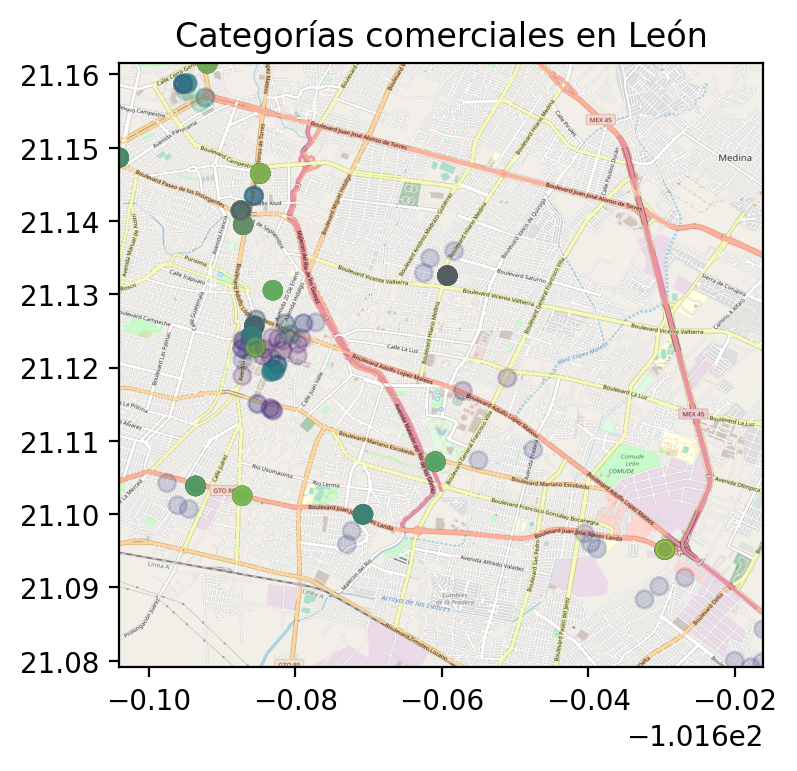

In [65]:
fig, ax = plt.subplots(dpi = 200)
ax.scatter(leon_df.longitud, leon_df.latitud, zorder=1, alpha= 0.2, c=pd.Categorical(leon_df['categoria']).codes*5, s=40)
ax.imshow(mapa_leon, zorder=0, extent = region_coord, aspect= 'equal')
ax.set_title('Categorías comerciales en León')

#ax.set_xlim(region_coord[0],region_coord[1])
#ax.set_ylim(region_coord[2],region_coord[3])

## Mapa interactivo de las categorías en León
Basado en el tutorial para crear mapas interactivos encontrado en:https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-raster-plots/interactive-maps/

In [67]:
import folium
from folium import plugins
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import earthpy as et

In [78]:
m = folium.Map(location=[21.121842, -101.681526], 
              tiles = 'Stamen Terrain')

for index, row in leon_df.iterrows():
    folium.Marker(
    location=[row['latitud'], row['longitud']],
    popup='Categoria: {},\n Rango de Precios: \n {} - {}'.format(row['categoria'], round(row['min_precio'],2), round(row['max_precio'],2)), 
    icon=folium.Icon()
).add_to(m)
m.fit_bounds([[21.080081, -101.701796], [21.167554, -101.634972]]) 
m

[1] https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude

--------------------------------------------------------------------------------------
Fuerza bruta para encontrar el mes en donde la canasta básica es más cara en Baja California.

In [13]:
query_most_exp_state_month = '''WITH data_estado AS (SELECT producto,
                          estado,
                           precio,
                          EXTRACT(MONTH FROM fechaRegistro) mes
                          FROM profeco
                          WHERE producto in ('REFRESCO', 'ACEITE', 'DETERGENTE P/ROPA', 'DESODORANTE') AND estado = 'BAJA CALIFORNIA'
                          )
                          
                        
                        
                                 
                            SELECT 
                                                           SUM(canasta.precio_med) costo_canasta
                                                      FROM (
                                                             SELECT 
                                                                   AVG(de.precio) precio_med
                                                             FROM data_estado as de
                                                             WHERE de.mes = '1'
                                                             GROUP BY de.producto
                                                             ) as canasta
                          
                        '''
sqlCtx.sql(query_most_exp_state_month).show(300, False)

+------------------+
|costo_canasta     |
+------------------+
|124.21863059702899|
+------------------+



In [16]:
query_most_exp_state_month = '''WITH data_estado AS (SELECT producto,
                          estado,
                           precio,
                          EXTRACT(MONTH FROM fechaRegistro) mes
                          FROM profeco
                          WHERE producto in ('REFRESCO', 'ACEITE', 'DETERGENTE P/ROPA', 'DESODORANTE') AND estado = 'BAJA CALIFORNIA'
                          )
                          
                        
                        
                                 
                            SELECT 
                                                           SUM(canasta.precio_med) costo_canasta
                                                      FROM (
                                                             SELECT 
                                                                   AVG(de.precio) precio_med
                                                             FROM data_estado as de
                                                             WHERE de.mes = '2'
                                                             GROUP BY de.producto
                                                             ) as canasta
                          
                        '''
sqlCtx.sql(query_most_exp_state_month).show(300, False)

+------------------+
|costo_canasta     |
+------------------+
|122.17035658707137|
+------------------+



In [19]:
query_most_exp_state_month = '''WITH data_estado AS (SELECT producto,
                          estado,
                           precio,
                          EXTRACT(MONTH FROM fechaRegistro) mes
                          FROM profeco
                          WHERE producto in ('REFRESCO', 'ACEITE', 'DETERGENTE P/ROPA', 'DESODORANTE') AND estado = 'BAJA CALIFORNIA'
                          )
                          
                        
                        
                                 
                            SELECT 
                                                           SUM(canasta.precio_med) costo_canasta
                                                      FROM (
                                                             SELECT 
                                                                   AVG(de.precio) precio_med
                                                             FROM data_estado as de
                                                             WHERE de.mes = '3'
                                                             GROUP BY de.producto
                                                             ) as canasta
                          
                        '''
sqlCtx.sql(query_most_exp_state_month).show(300, False)

+------------------+
|costo_canasta     |
+------------------+
|121.40147824062689|
+------------------+



In [20]:
query_most_exp_state_month = '''WITH data_estado AS (SELECT producto,
                          estado,
                           precio,
                          EXTRACT(MONTH FROM fechaRegistro) mes
                          FROM profeco
                          WHERE producto in ('REFRESCO', 'ACEITE', 'DETERGENTE P/ROPA', 'DESODORANTE') AND estado = 'BAJA CALIFORNIA'
                          )
                          
                        
                        
                                 
                            SELECT 
                                                           SUM(canasta.precio_med) costo_canasta
                                                      FROM (
                                                             SELECT 
                                                                   AVG(de.precio) precio_med
                                                             FROM data_estado as de
                                                             WHERE de.mes = '4'
                                                             GROUP BY de.producto
                                                             ) as canasta
                          
                        '''
sqlCtx.sql(query_most_exp_state_month).show(300, False)

+------------------+
|costo_canasta     |
+------------------+
|123.39152212246587|
+------------------+



In [21]:
query_most_exp_state_month = '''WITH data_estado AS (SELECT producto,
                          estado,
                           precio,
                          EXTRACT(MONTH FROM fechaRegistro) mes
                          FROM profeco
                          WHERE producto in ('REFRESCO', 'ACEITE', 'DETERGENTE P/ROPA', 'DESODORANTE') AND estado = 'BAJA CALIFORNIA'
                          )
                          
                        
                        
                                 
                            SELECT 
                                                           SUM(canasta.precio_med) costo_canasta
                                                      FROM (
                                                             SELECT 
                                                                   AVG(de.precio) precio_med
                                                             FROM data_estado as de
                                                             WHERE de.mes = '5'
                                                             GROUP BY de.producto
                                                             ) as canasta
                          
                        '''
sqlCtx.sql(query_most_exp_state_month).show(300, False)

+------------------+
|costo_canasta     |
+------------------+
|122.15086824508536|
+------------------+



In [22]:
query_most_exp_state_month = '''WITH data_estado AS (SELECT producto,
                          estado,
                           precio,
                          EXTRACT(MONTH FROM fechaRegistro) mes
                          FROM profeco
                          WHERE producto in ('REFRESCO', 'ACEITE', 'DETERGENTE P/ROPA', 'DESODORANTE') AND estado = 'BAJA CALIFORNIA'
                          )
                          
                        
                        
                                 
                            SELECT 
                                                           SUM(canasta.precio_med) costo_canasta
                                                      FROM (
                                                             SELECT 
                                                                   AVG(de.precio) precio_med
                                                             FROM data_estado as de
                                                             WHERE de.mes = '6'
                                                             GROUP BY de.producto
                                                             ) as canasta
                          
                        '''
sqlCtx.sql(query_most_exp_state_month).show(300, False)

+------------------+
|costo_canasta     |
+------------------+
|117.54057556675967|
+------------------+



In [23]:
query_most_exp_state_month = '''WITH data_estado AS (SELECT producto,
                          estado,
                           precio,
                          EXTRACT(MONTH FROM fechaRegistro) mes
                          FROM profeco
                          WHERE producto in ('REFRESCO', 'ACEITE', 'DETERGENTE P/ROPA', 'DESODORANTE') AND estado = 'BAJA CALIFORNIA'
                          )
                          
                        
                        
                                 
                            SELECT 
                                                           SUM(canasta.precio_med) costo_canasta
                                                      FROM (
                                                             SELECT 
                                                                   AVG(de.precio) precio_med
                                                             FROM data_estado as de
                                                             WHERE de.mes = '7'
                                                             GROUP BY de.producto
                                                             ) as canasta
                          
                        '''
sqlCtx.sql(query_most_exp_state_month).show(300, False)

+------------------+
|costo_canasta     |
+------------------+
|118.44921120025896|
+------------------+



In [24]:
query_most_exp_state_month = '''WITH data_estado AS (SELECT producto,
                          estado,
                           precio,
                          EXTRACT(MONTH FROM fechaRegistro) mes
                          FROM profeco
                          WHERE producto in ('REFRESCO', 'ACEITE', 'DETERGENTE P/ROPA', 'DESODORANTE') AND estado = 'BAJA CALIFORNIA'
                          )
                          
                        
                        
                                 
                            SELECT 
                                                           SUM(canasta.precio_med) costo_canasta
                                                      FROM (
                                                             SELECT 
                                                                   AVG(de.precio) precio_med
                                                             FROM data_estado as de
                                                             WHERE de.mes = '8'
                                                             GROUP BY de.producto
                                                             ) as canasta
                          
                        '''
sqlCtx.sql(query_most_exp_state_month).show(300, False)

+------------------+
|costo_canasta     |
+------------------+
|118.02625955742724|
+------------------+



In [25]:
query_most_exp_state_month = '''WITH data_estado AS (SELECT producto,
                          estado,
                           precio,
                          EXTRACT(MONTH FROM fechaRegistro) mes
                          FROM profeco
                          WHERE producto in ('REFRESCO', 'ACEITE', 'DETERGENTE P/ROPA', 'DESODORANTE') AND estado = 'BAJA CALIFORNIA'
                          )
                          
                        
                        
                                 
                            SELECT 
                                                           SUM(canasta.precio_med) costo_canasta
                                                      FROM (
                                                             SELECT 
                                                                   AVG(de.precio) precio_med
                                                             FROM data_estado as de
                                                             WHERE de.mes = '9'
                                                             GROUP BY de.producto
                                                             ) as canasta
                          
                        '''
sqlCtx.sql(query_most_exp_state_month).show(300, False)

+------------------+
|costo_canasta     |
+------------------+
|117.06470364242742|
+------------------+



In [26]:
query_most_exp_state_month = '''WITH data_estado AS (SELECT producto,
                          estado,
                           precio,
                          EXTRACT(MONTH FROM fechaRegistro) mes
                          FROM profeco
                          WHERE producto in ('REFRESCO', 'ACEITE', 'DETERGENTE P/ROPA', 'DESODORANTE') AND estado = 'BAJA CALIFORNIA'
                          )
                          
                        
                        
                                 
                            SELECT 
                                                           SUM(canasta.precio_med) costo_canasta
                                                      FROM (
                                                             SELECT 
                                                                   AVG(de.precio) precio_med
                                                             FROM data_estado as de
                                                             WHERE de.mes = '10'
                                                             GROUP BY de.producto
                                                             ) as canasta
                          
                        '''
sqlCtx.sql(query_most_exp_state_month).show(300, False)

+------------------+
|costo_canasta     |
+------------------+
|119.78351058375425|
+------------------+



In [3]:
query_most_exp_state_month = '''WITH data_estado AS (SELECT producto,
                          estado,
                           precio,
                          EXTRACT(MONTH FROM fechaRegistro) mes
                          FROM profeco
                          WHERE producto in ('REFRESCO', 'ACEITE', 'DETERGENTE P/ROPA', 'DESODORANTE') AND estado = 'BAJA CALIFORNIA'
                          )
                          
                        
                        
                                 
                            SELECT 
                                                           SUM(canasta.precio_med) costo_canasta
                                                      FROM (
                                                             SELECT 
                                                                   AVG(de.precio) precio_med
                                                             FROM data_estado as de
                                                             WHERE de.mes = '11'
                                                             GROUP BY de.producto
                                                             ) as canasta
                          
                        '''
sqlCtx.sql(query_most_exp_state_month).show(300, False)

+------------------+
|costo_canasta     |
+------------------+
|120.12065013028298|
+------------------+



In [4]:
query_most_exp_state_month = '''WITH data_estado AS (SELECT producto,
                          estado,
                           precio,
                          EXTRACT(MONTH FROM fechaRegistro) mes
                          FROM profeco
                          WHERE producto in ('REFRESCO', 'ACEITE', 'DETERGENTE P/ROPA', 'DESODORANTE') AND estado = 'BAJA CALIFORNIA'
                          )
                          
                        
                        
                                 
                            SELECT 
                                                           SUM(canasta.precio_med) costo_canasta
                                                      FROM (
                                                             SELECT 
                                                                   AVG(de.precio) precio_med
                                                             FROM data_estado as de
                                                             WHERE de.mes = '12'
                                                             GROUP BY de.producto
                                                             ) as canasta
                          
                        '''
sqlCtx.sql(query_most_exp_state_month).show(300, False)

+------------------+
|costo_canasta     |
+------------------+
|121.23422668080028|
+------------------+

